# Cleaned up decomposed time series

In [1]:
import numpy as np 
import cartopy
import cartopy.crs as ccrs
import matplotlib
matplotlib.interactive(True)
import cmocean
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings; warnings.simplefilter('ignore')
# %matplotlib notebook

In [2]:
path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'
region = 'HB'

In [31]:
def load_ice(filepath, region, array):
    nc = Dataset(filepath + region + '.nc', 'r')
    lon = nc.variables['longitude'][600:1450,1700:]
    lat = nc.variables['latitude'][600:1450,1700:]
#     land = nc.variables['land'][600:1450,1700:]
    juld = nc.variables['juld'][:]

    data = nc.variables[array][:,600:1450,1700:]

    if array == 'E_CT':
        E_CT=data
        # Convert concentration egg codes to actual concentrations
        CT = np.nan*np.ones(data.shape)
        CT[E_CT==1] = 10
        CT[E_CT==2] = 20
        CT[E_CT==3] = 30
        CT[E_CT==4] = 40
        CT[E_CT==5] = 50
        CT[E_CT==6] = 60
        CT[E_CT==7] = 70
        CT[E_CT==8] = 80
        CT[E_CT==9] = 90
        CT[E_CT==10] = 95
        CT[E_CT==11] = 100
        
        eggcode = CT
        
    if array == 'E_SA':
        E_SA=data
        # Convert stage of formation into some actual thicknesses
        # got the list of all values present from np.unique(E_SA)
        h_A = np.nan*np.ones(data.shape)
        h_A[E_SA==1] = 0.05
        h_A[E_SA==4] = 0.125
        h_A[E_SA==5] = 0.225
        h_A[E_SA==7] = 0.50
        h_A[E_SA==10] = 0.95
        h_A[E_SA==11] = 1.60
        h_A[E_SA==12] = 2.50
        
        eggcode = h_A
        

    return lon, lat, juld, eggcode

In [46]:
def trend(x, y, alpha=0.05):
    '''
    Calculates the trend of y given the linear
    independent variable x. Outputs the mean,
    trend, and alpha-level (e.g., 0.05 for 95%)
    confidence limit on the trend.
    returns mean, trend, dtrend_95
    '''
    valid = ~np.isnan(y)
    if valid.sum() <= 1:
        return np.nan, np.nan, np.nan
    else:
        X = np.array([np.ones(len(x)), x-x.mean()])
        beta = np.linalg.lstsq(X[:,valid].T, y[valid])[0]
        yhat = np.sum(beta*X.T, axis=1)
        t_stat = stats.t.isf(alpha/2, len(x[valid])-2)
        s = np.sqrt(np.sum((y[valid] - yhat[valid])**2) / (len(x[valid])-2))
        Sxx = np.sum(X[1,valid]**2) - (np.sum(X[1,valid])**2)/len(x[valid]) # np.var(X, axis=1)[1]
        return beta[0], beta[1], t_stat * s / np.sqrt(Sxx)


def find_trends(t_domain, lon, lat, juld, array):
    '''
    Calculates montly means and trends. t_domain is a string that specifies what domain to analyze (monthly or total)
    array is the data to be analyzed (ie. concentration, thickness)
    '''
    if t_domain == 'monthly':
        # Convert dates
        d0ord = date(1950,1,1).toordinal()
        dt_ordinal = d0ord + juld
        dates = [date.fromordinal(dt_ordinal[tt]) for tt in range(len(juld))]
        months = [dates[tt].month for tt in range(len(juld))]
        months_unique = np.unique(months)

        # Calculate monthly means and subtract them from time series
        dCT_monthly=[]
        month_occurences=[]
        for month in months_unique:
            inds = np.array(months)==month
            # Monthly means
            # ybar_monthly.append(np.nanmean(CT[inds,:,:],axis=0))
            # Subtract mean from time series
            dCT_monthly.append(CT[inds,:,:] - np.nanmean(CT[inds,:,:],axis=0))
            # Indices of dates within each month
            month_occurences.append(juld[inds])

        n = np.shape(lon)[0]
        m = np.shape(lon)[1]
        p = len(months_unique)

        ytrend_monthly = np.zeros((p,n,m))
        dtrend_95_monthly = np.zeros((p,n,m))
        ybar_monthly = np.zeros((p,n,m))

        # Calculate trends along time axis
        for month in range(len(months_unique)):
            for i in range(n):
                for j in range(m):
                    mean, tr, dt95 = trend(month_occurences[month], dCT_monthly[month][:,i,j])
                    ytrend_monthly[month,i,j] = tr
                    dtrend_95_monthly[month,i,j] = dt95
                    ybar_monthly[month,i,j] = mean

        
        return ybar_monthly, ytrend_monthly, dtrend_95_monthly
    
    if t_domain == 'total':
        # Mean of entire time series
        ybarCT = np.nanmean(CT, axis=0)

        # Subtract the mean from the time series
        dCT = CT - ybarCT

        n = np.shape(lon)[0]
        m = np.shape(lon)[1]
        ytrend=np.zeros((n,m))
        dtrend_95=np.zeros((n,m))
        ybar=np.zeros((n,m))

        # Calculate trends along time axis
        for i in range(n):
            for j in range(m):
                mean, tr, dt95 = trend(juld, dCT[:,i,j])
                ytrend[i,j] = tr
                dtrend_95[i,j] = dt95
                ybar[i,j] = mean

        return ybar, ytrend, dtrend_95



In [53]:
def decomp(lon,lat,juld,eggcode,grouping):
    
    # Convert dates
    d0ord = date(1950,1,1).toordinal()
    dt_ordinal = d0ord + juld

    dates = [date.fromordinal(dt_ordinal[tt]) for tt in range(len(juld))]
    years = [dates[tt].year for tt in range(len(juld))]
    months = [dates[tt].month for tt in range(len(juld))]
    days = [dates[tt].day for tt in range(len(juld))]

    months_unique = np.unique(months)
    n = np.shape(lon)[0] # shape of lon
    m = np.shape(lat)[1]
    # Calculate monthly means and subtract them from time series
    ybar_monthly=[]
    darr_monthly=[]
    month_occurences=[]

    if grouping=='monthly':
        tic = time.time()
        for month in months_unique:
            inds = np.array(months)==month
            # Monthly median
            ybar_monthly.append(np.nanmedian(eggcode[inds,:,:],axis=0))
            # Subtract median from time series
            darr_monthly.append(eggcode[inds,:,:] - np.nanmedian(eggcode[inds,:,:],axis=0))
            # Indices of dates within each month
            month_occurences.append(juld[inds])

        ybar_monthly = np.array(ybar_monthly)
        ybar_monthly[ybar_monthly==0]=np.nan
        
        ytrend_monthly = np.zeros((len(ybar_monthly),n,m))
        dtrend_95_monthly = np.zeros((len(ybar_monthly),n,m))

        # Calculate trends along time axis
        for month in range(len(months_unique)):
            for i in range(n):
                for j in range(m):
        #             idx = np.isfinite(month_occurences[month]) & np.isfinite(dCT_monthly[month][:,i,j])
        #             if idx.any()==True:
                    mean, tr, dt95 = trend(month_occurences[month], darr_monthly[month][:,i,j])
                    ytrend_monthly[month,i,j] = tr
                    dtrend_95_monthly[month,i,j] = dt95

        toc = time.time()
        print(toc-tic)
        
        return ybar_monthly, ytrend_monthly, dtrend_95_monthly
    
    if grouping=='seasonal':
        tic=time.time()
        ybar_seasonal = []
        darr_seasonal = []
        # Remove Aug, Sept, Oct and rearrange so array starts November
        idx = [11,12,1,2,3,4,5,6,7]
        
        for s in np.arange(0,9,3):
            inds = (np.array(months)==idx[s]) | (np.array(months)==s+1) | (np.array(months)==s+2)
            # Monthly medians
            ybar_seasonal.append(np.nanmedian(eggcode[inds,:,:],axis=0))
            # Subtract mean from time series
            darr_seasonal.append(eggcode[inds,:,:] - np.nanmedian(eggcode[inds,:,:],axis=0))
            # Indices of dates within each month
            month_occurences.append(juld[inds])

        ybar_seasonal = np.array(ybar_seasonal)
        ybar_seasonal[ybar_seasonal==0]=np.nan
                
        ytrend_seasonal = np.zeros((len(ybar_seasonal),n,m))
        dtrend_95_seasonal = np.zeros((len(ybar_seasonal),n,m))

        # Calculate trends along time axis
        for s in range(len(month_occurences)):
            for i in range(n):
                for j in range(m):
        #             idx = np.isfinite(month_occurences[month]) & np.isfinite(dCT_monthly[month][:,i,j])
        #             if idx.any()==True:
                    mean, tr, dt95 = trend(month_occurences[s], darr_seasonal[s][:,i,j])
                    ytrend_seasonal[s,i,j] = tr
                    dtrend_95_seasonal[s,i,j] = dt95

        toc = time.time()
        print(toc-tic)       
        
        return ybar_seasonal, ytrend_seasonal, dtrend_95_seasonal

In [9]:
def hatch(array,dtrend_95):
    # Hatching for monthly trends
    hatched = np.zeros(np.shape(array))
    for i in range(len(array)):
        sign = np.sign(array[i,:,:])
#     hatched = np.zeros(np.shape(ytrend_monthly[i,:,:]))
        for (x,y), value in np.ndenumerate(sign):
            if np.sign(array[i,x,y] + dtrend_95[i,x,y]) != value or np.sign(array[i,x,y] - dtrend_95[i,x,y]) != value:
                # Create array for hatching. Ones represent non-significant values
                hatched[i,x,y]=1
    # Make nans insignificant
    hatched[np.isnan(hatched)==True]=1
    
    return hatched

In [50]:
def mapit(lon,lat,array,dtrend_95=None, grouping=None, cmap=None, vmin=None, vmax=None):
    
    '''Optional arguments: dtrend_95, grouping, cmap, vmin, vmax'''
    if dtrend_95 != None:
        hatched = hatch(array, dtrend_95)

    
    # Set up cartopy map      

    #Declare the land and ocean parameters
    LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
    edgecolor='black',
    facecolor=('silver'),
    linewidth=1)
    OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
    facecolor='dimgrey')

    #Declare the lat and lon boundaries for the map and data
    domain = [99, 99, -99, -99]
    domain[0] = np.min(lat) # South
    domain[1] = np.min(lon) # West
    domain[2] = np.max(lat) # North
    domain[3] = np.max(lon) # East
#     domain = list(np.array(domain) + np.array([+1, +6, 0, -4]))
    domain = [53.58105923668295, -61.30979545701268, 61.589404038199575, -56.47452933956656]


    aoi_map = [domain[0], domain[2], domain[1], domain[3]]
    # Rotation for vertical coast
    rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

    # Plot results
    transform = rot.transform_points(rot,lon,lat)
    x_n = transform[...,0]
    y_n = transform[...,1]
    
    if grouping==None:
        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(1,1,1, projection=rot)
        ax.add_feature(LAND_highres,zorder=2)
        ax.add_feature(OCEAN_highres,zorder=3)
        ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
        ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
        im = plt.pcolormesh(x_n,y_n,array,transform=ccrs.PlateCarree(),zorder=4,cmap=cmap,vmin=vmin,vmax=vmax)  
        
    if grouping=='monthly':
        fig = plt.figure(figsize=(10,7))
        months_str = ['January','February','March','April','May','June','July',
                 'August','September','October','November','December']
        # js are here for reordering plots to start from ice season 
        j=8
        for i in range(1,13):
            if j==12:
                j=0
            ax = fig.add_subplot(3, 4, i, projection=rot)
            ax.add_feature(LAND_highres,zorder=2)
            ax.add_feature(OCEAN_highres,zorder=3)
            ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
            ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
            im = plt.pcolormesh(x_n,y_n,array[j,:,:],transform=ccrs.PlateCarree(),zorder=4,cmap=cmap,vmin=vmin,vmax=vmax)  
    #         plt.contourf(x_n,y_n,hatched[j,:,:],levels=1, hatches=['//', ''],  alpha=0.,transform=ccrs.PlateCarree(),zorder=5)
            plt.title(months_str[j])
            j+=1
    
    if grouping=='seasonal':
        fig = plt.figure(figsize=(10,5))
        season_str = ['Growing (Nov-Jan)', 'Peak (Feb-Apr)', 'Melt (May-Jul)']
        for i in range(len(array)):
            ax = fig.add_subplot(1, 3, i+1, projection=rot)
            ax.add_feature(LAND_highres,zorder=2)
            ax.add_feature(OCEAN_highres,zorder=3)
            ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
            ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
            im = plt.pcolormesh(x_n,y_n,array[i,:,:],transform=ccrs.PlateCarree(),cmap=cmap, zorder=4,vmin=vmin,vmax=vmax)  
#             plt.contourf(x_n,y_n,hatched[i,:,:],levels=1, hatches=['//', ''],  alpha=0.,transform=ccrs.PlateCarree(),zorder=5)
            plt.title(season_str[i])
            i+=1       
        

    fig.subplots_adjust(bottom=0.03, top=0.9, left=0.1, right=0.8,
                        wspace=0.2, hspace=0.2)
 
    return im, fig
    

# Concentration

In [32]:
lon, lat, juld, CT = load_ice(path,region,'E_CT')

In [ ]:
ybar_monthly, ytrend_monthly, dtrend_95_monthly = decomp(lon,lat,juld,CT,'monthly')

In [47]:
ybar_seasonal, ytrend_seasonal, dtrend_95_seasonal = decomp(lon,lat,juld,CT,'seasonal')

776.7694628238678


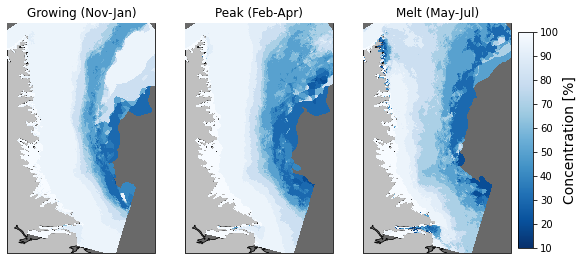

In [51]:
# Seasonal Concentration using median 

im, fig = mapit(lon,lat,ybar_seasonal,grouping='seasonal',cmap='Blues_r',vmin=10,vmax=100)
cb_ax = fig.add_axes([0.81, 0.16, 0.02, 0.6]) # left, bottom, width, height
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Concentration [%]',fontsize=14)
# plt.savefig('/home/mwang/figures/CT_new.png')

In [227]:
np.shape(hatched)

(3, 850, 954)

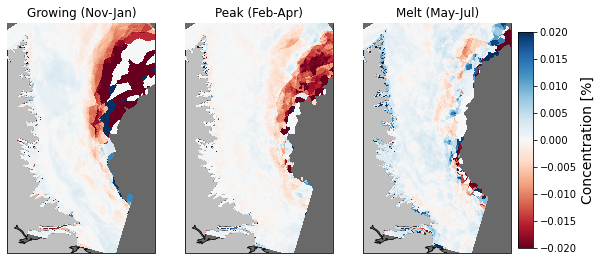

In [26]:
im, fig = mapit(lon,lat,ytrend_seasonal,dtrend_95_seasonal,'seasonal',cmap='RdBu',vmin=-0.02,vmax=0.02)
cb_ax = fig.add_axes([0.81, 0.16, 0.02, 0.6]) # left, bottom, width, height
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Concentration [%]',fontsize=14)
plt.savefig('/home/mwang/CTtrend_new.png')

# Thickness

In [52]:
lon, lat, juld, HA = load_ice(path,region,'E_SA')

In [54]:
ybar_HA_seas, ytrend_HA_seas, dtrend_95_HA_seas = decomp(lon,lat,juld,HA,'seasonal')

771.2729330062866


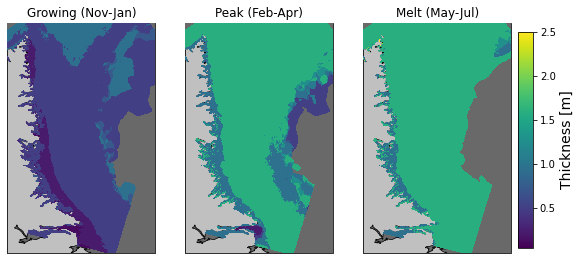

In [57]:
# Seasonal thickness using median

im, fig = mapit(lon,lat,ybar_HA_seas,grouping='seasonal',vmin=0.05,vmax=2.5)
cb_ax = fig.add_axes([0.81, 0.16, 0.02, 0.6]) # left, bottom, width, height
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Thickness [m]',fontsize=14)
# plt.savefig('/home/mwang/seasonal_HA.png')

In [ ]:
im, fig = mapit(lon,lat,ytrend_HA_seas,dtrend_95_HA_seas,'seasonal',cmap='RdBu',vmin=-0.0001,vmax=0.0001)
cb_ax = fig.add_axes([0.82, 0.16, 0.02, 0.6]) # left, bottom, width, height
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Thickness [m]',fontsize=14)
cbar.formatter.set_powerlimits((0, 0))

# plt.savefig('/home/mwang/seasonaltrend_HA.png')

# Plot Medians

In [4]:
lon, lat, juld, HA = load_ice(path,region,'E_SA')

In [33]:
HA_med = np.nanmedian(HA,axis=0)
CT_med = np.nanmedian(CT,axis=0)

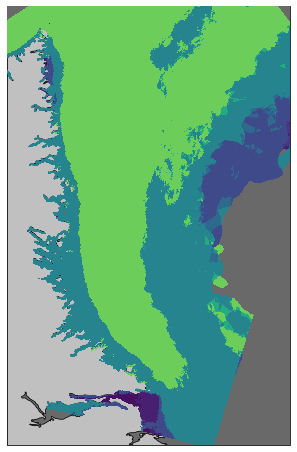

In [40]:
mapit(lon,lat,HA_med)
cbar = fig.colorbar(im)
cbar.set_label('Thickness [m]',fontsize=14)

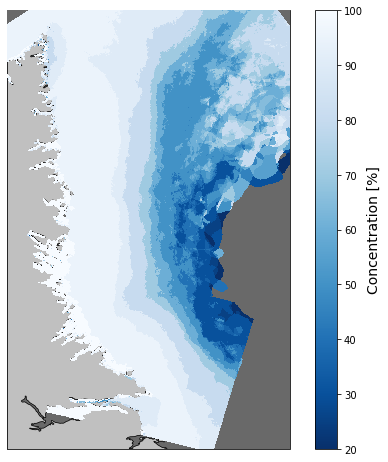

In [38]:
im,fig = mapit(lon,lat,CT_med,cmap='Blues_r')
cbar = fig.colorbar(im)
cbar.set_label('Concentration [%]',fontsize=14)